In [1]:
import pandas as pd
import re
import numpy as np
from scipy import stats
import scipy as sp
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns

# from bayesian_player_ratings import ratings
from bayesian_player_ratings import *

import os
import warnings
warnings.filterwarnings('ignore')
pd.options.display.max_rows = 999
pd.options.display.max_columns = 999
pd.set_option('display.precision', 4)

Load Match Summary Data

In [2]:
match_summary = pd.read_csv("/Users/ciaran/Documents/Projects/AFL/data/match_summary.csv")
match_summary = score_col_splitter(match_summary, "Q4_Score")
match_summary['Season'] = match_summary['Match_ID'].apply(lambda x: int(x[:4]))

player_stats = pd.read_csv("/Users/ciaran/Documents/Projects/AFL/data/scored_player_stats.csv")
player_stats = create_additional_player_stats_variables(player_stats)
player_stats['exp_vaep_value'] = player_stats['exp_vaep_value'].fillna(0)
player_stats['exp_offensive_value'] = player_stats['exp_offensive_value'].fillna(0)
player_stats['exp_defensive_value'] = player_stats['exp_defensive_value'].fillna(0)

match_stats = aggregate_player_to_match_stats(player_stats)

match_summary_stats = match_summary.merge(match_stats, how = "left", on = "Match_ID")

In [3]:
player_stats_2021 = player_stats[player_stats['Season'] == 2021]
team_summary_2021 = create_team_summary(player_stats_2021)

player_stats_2022 = player_stats[player_stats['Season'] == 2022]
team_summary_2022 = create_team_summary(player_stats_2022)

player_stats_2023 = player_stats[player_stats['Season'] == 2023]
team_summary_2023 = create_team_summary(player_stats_2023)

Team Ratings

- Individual player ratings based on past Expected VAEP values
- Team ratings are the combined player ratings for whoever is playing
- Home advantage is some multiplier/adjustment that is applied to home/away team
- Predicted match outcome, probability, margin is based on both team's ratings
- Match happens
- Actual match outcome, margin is available
- Expected VAEP values for each player is available for latest game
- Player ratings are updated based on their Expected VAEP in the match compared to their prior Expected VAEP (HA-neutral)
- Team ratings are (either) updated based on new player ratings (or) updated based on actual margin compared to predicted margin (HA-neutral)

Initialise Player Values from 2021

In [4]:
player_stats_2021 = player_stats[player_stats['Season'] == 2021]
match_summary_stats_2021 = match_summary_stats[match_summary_stats['Season'] == 2021]

In [5]:
ratings = TeamRatings()
ratings.calculate_home_advantage(match_summary_stats_2021)
ratings.initialise_player_values(player_stats_2021)
ratings.initialise_player_stds(player_stats_2021)

In [6]:
ratings.home_advantage = match_summary_stats['Home_exp_vaep_value'].mean() - match_summary_stats['Away_exp_vaep_value'].mean()

In [7]:
ratings.home_advantage

6.562920467953816

In [ ]:
ratings.player_values['Start'].sort_values(by="Value", ascending = False).head()

In [8]:
ratings.initialise_team_values(player_stats_2021)

In [9]:
ratings.team_values['Start'].sort_values(by="Value", ascending = False)

,Team,Value,Offensive_Value,Defensive_Value
10,Melbourne,26.1672,120.4591,94.2918
17,Western Bulldogs,19.1769,123.0902,103.9133
1,Brisbane Lions,18.5923,125.3434,106.7511
12,Port Adelaide,12.0691,113.7886,101.7195
6,Geelong,11.2814,112.5066,101.2253
15,Sydney,4.4038,115.9393,111.5354
4,Essendon,2.6013,113.0918,110.4905
13,Richmond,-1.4210,106.5975,108.0186
8,Greater Western Sydney,-1.5189,109.9890,111.5079
2,Carlton,-2.8461,115.5673,118.4135


In [10]:
(match_stats['Home_exp_vaep_value'] - match_stats['Away_exp_vaep_value']).std()

34.150375543408046

Round 202201

In [11]:
def calculate_predicted_match_ratings(self, player_stats, round_id, match_id):
    home_players = self.get_home_players(player_stats, match_id)
    home_predicted_rating = self.player_values[round_id][self.player_values[round_id]['Player'].isin(home_players)]['Value'].sum()

    away_players = self.get_away_players(player_stats, match_id)
    away_predicted_rating = self.player_values[round_id][self.player_values[round_id]['Player'].isin(away_players)]['Value'].sum()
    
    return home_predicted_rating, away_predicted_rating

In [12]:
def get_teams(match_id):
    
    home_team = re.sub(r"\B([A-Z])", r" \1", match_id.split("_")[1])
    away_team = re.sub(r"\B([A-Z])", r" \1", match_id.split("_")[-1])

    return home_team, away_team

In [13]:
match_id = '202201_StKilda_Collingwood'
home_team, away_team = get_teams(match_id)
home_players = ratings.get_home_players(player_stats, match_id)
away_players = ratings.get_away_players(player_stats, match_id)
# home_rating_for, away_rating_for = calculate_predicted_match_ratings(ratings, player_stats, round_id="Start", match_id=match_id)
home_rating_for = ratings.team_values['Start'][ratings.team_values['Start']['Team'] == home_team]['Offensive_Value'].iloc[0]
away_rating_for = ratings.team_values['Start'][ratings.team_values['Start']['Team'] == away_team]['Offensive_Value'].iloc[0]
home_rating_for_ha = home_rating_for + (ratings.home_advantage)*0.5
home_rating_against = ratings.team_values['Start'][ratings.team_values['Start']['Team'] == home_team]['Defensive_Value'].iloc[0]
home_rating_against_ha = home_rating_against - ratings.home_advantage*0.5
away_rating_against = ratings.team_values['Start'][ratings.team_values['Start']['Team'] == away_team]['Defensive_Value'].iloc[0]

In [18]:
home_rating = home_rating_for - away_rating_against
away_rating = away_rating_for - home_rating_against
home_rating_for, away_rating_against, home_rating, away_rating_for, home_rating_against, away_rating

(106.38706769857254,
 109.6829684607656,
 -3.2959007621930567,
 102.28264354233,
 111.11802761076665,
 -8.835384068436639)

In [17]:
home_rating_ha = home_rating_for_ha - away_rating_against
away_rating_ha = away_rating_for - home_rating_against_ha
home_rating_for_ha, away_rating_against, home_rating_ha, away_rating_for, home_rating_against_ha, away_rating_ha

(109.66852793254944,
 109.6829684607656,
 -0.014440528216155712,
 102.28264354233,
 107.83656737678973,
 -5.553923834459724)

In [20]:
1 / (1 + 10**((away_rating - home_rating - ratings.home_advantage)/35)), 1 / (1 + 10**((away_rating_ha - home_rating_ha)/35))

(0.6891599027971322, 0.5901129520580578)

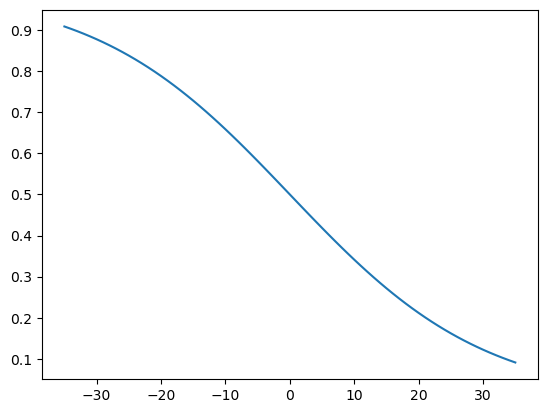

In [21]:
x = np.linspace(-35, 35, 71)
y = 1 / (1 + 10**((x)/35))
plt.plot(x, y)

In [24]:
actual_match = match_summary_stats[match_summary_stats['Match_ID'] == match_id]
home_actual = actual_match['Home_exp_vaep_value'].iloc[0]
away_actual = actual_match['Away_exp_vaep_value'].iloc[0]
actual_rating_diff = home_actual - away_actual
home_actual, away_actual, actual_rating_diff

(118.3345500385, 124.960551953758, -6.626001915258001)

In [41]:
home_rating, home_rating_for, home_rating_against

(-3.2959007621930567, 106.38706769857254, 111.11802761076665)

In [42]:
home_rating_ha, home_rating_for_ha, home_rating_against_ha

(-0.014440528216155712, 109.66852793254944, 107.83656737678973)

In [43]:
actual_rating_diff, home_actual, away_actual

(-6.626001915258001, 118.3345500385, 124.960551953758)

In [40]:
home_off_diff = home_actual - home_rating_for_ha
home_def_diff = home_rating_against_ha - away_actual
home_off_diff, home_def_diff, home_off_diff + home_def_diff

(8.66602210595056, -17.12398457696827, -8.457962471017709)

In [44]:
away_rating, away_rating_for, away_rating_against

(-8.835384068436639, 102.28264354233, 109.6829684607656)

In [45]:
-actual_rating_diff, away_actual, home_actual

(6.626001915258001, 124.960551953758, 118.3345500385)

In [46]:
away_off_diff = away_actual - away_rating_for
away_def_diff = away_rating_against - home_actual
away_off_diff, away_def_diff, away_off_diff + away_def_diff

(22.677908411427993, -8.651581577734405, 14.026326833693588)

In [47]:
home_off_diff + home_def_diff + away_off_diff + away_def_diff

5.568364362675879

Elo example

In [48]:
k = 0.2

In [49]:
# Expected Result
expected_result = (home_rating_for - away_rating_against) - (away_rating_for - home_rating_against)
# Actual result
actual_result = home_actual - away_actual

new_home_rating = home_rating + k * (actual_result - expected_result)
(home_rating_for - away_rating_against), new_home_rating

(-3.2959007621930567, -5.728997806493373)

In [58]:
# Expected Result
expected_result = (away_rating_for - home_rating_against) - (home_rating_for - away_rating_against)
# Actual result
actual_result = away_actual - home_actual

new_away_rating = away_rating + k * (actual_result - expected_result)
(away_rating_for - home_rating_against), new_away_rating

(-8.835384068436639, -6.402287024136323)

Elo Example Home

In [52]:
# Expected Result
expected_result = home_rating_for
# Actual result
actual_result = home_actual

new_home_rating_for = home_rating_for + k * (actual_result - expected_result)
expected_result, actual_result, new_home_rating_for

(106.38706769857254, 118.3345500385, 108.77656416655803)

In [53]:
# Expected Result
expected_result = home_rating_against
# Actual result
actual_result = away_actual

new_home_rating_against = home_rating_against + k * (actual_result - expected_result)
expected_result, actual_result, new_home_rating_against

(111.11802761076665, 124.960551953758, 113.88653247936492)

ELO Example Away

In [54]:
# Expected Result
expected_result = away_rating_for
# Actual result
actual_result = away_actual

new_away_rating_for = away_rating_for + k * (actual_result - expected_result)
expected_result, actual_result, new_away_rating_for

(102.28264354233, 124.960551953758, 106.8182252246156)

In [55]:
# Expected Result
expected_result = away_rating_against
# Actual result
actual_result = home_actual

new_away_rating_against = away_rating_against + k * (actual_result - expected_result)
away_rating_against, new_away_rating_against

(109.6829684607656, 111.41328477631248)

In [62]:
new_home_rating_for, new_home_rating_against, new_home_rating, new_home_rating_for - new_home_rating_against

(108.77656416655803,
 113.88653247936492,
 -5.728997806493373,
 -5.109968312806885)

In [63]:
new_away_rating_for, new_away_rating_against, new_away_rating, new_away_rating_for - new_away_rating_against

(106.8182252246156,
 111.41328477631248,
 -6.402287024136323,
 -4.5950595516968775)

In [ ]:
ratings.update_round_values(player_stats, round_id = "202201")

In [ ]:
ratings.player_values[ratings.latest_round].sort_values(by="Offensive_Value", ascending = False).head()

In [ ]:
ratings.player_values[ratings.latest_round].sort_values(by="Defensive_Value", ascending = False).head()

In [ ]:
ratings.get_squad_ratings(player_stats, round_id = "202201").sort_values(by="Rating", ascending = False)

In [ ]:
ratings.get_team_ratings(player_stats, round_id = "202201").sort_values(by="Rating", ascending = False)

In [ ]:
ratings.player_values[ratings.latest_round][ratings.player_values[ratings.latest_round]['Player'].isin(geelong_players)].sort_values("Offensive_Value", ascending = False).head(10)

In [ ]:
player_stats[(player_stats['Round_ID'] == ratings.latest_round) & (player_stats['Player'] == "Patrick Dangerfield")]

In [ ]:
ratings.player_values["Start"][ratings.player_values["Start"]['Player'] == "Patrick Dangerfield"]

In [ ]:
ratings.player_values["202201"][ratings.player_values["202201"]['Player'] == "Patrick Dangerfield"]

Round 202202

In [ ]:
ratings.update_round_values(player_stats, round_id = "202202")

In [ ]:
ratings.player_values[ratings.latest_round].sort_values(by='Offensive_Value', ascending = False).head(10)

In [ ]:
ratings.player_values[ratings.latest_round].sort_values(by='Defensive_Value', ascending = False).head(10)

In [ ]:
ratings.get_team_ratings(player_stats, round_id = "202202").sort_values(by="Rating", ascending = False)

In [ ]:
ratings.player_values[ratings.latest_round][ratings.player_values[ratings.latest_round]['Player'].isin(geelong_players)].sort_values("Offensive_Value", ascending = False).head(10)

In [ ]:
ratings.player_values[ratings.latest_round][ratings.player_values[ratings.latest_round]['Player'] == "Patrick Dangerfield"]

In [ ]:
ratings.player_values["202201"][ratings.player_values["202201"]['Player'] == "Patrick Dangerfield"]

202203

In [ ]:
ratings.update_round_values(player_stats, round_id = "202203")

In [ ]:
ratings.player_values[ratings.latest_round].sort_values(by='Offensive_Value', ascending = False).head(5)

In [ ]:
ratings.player_values[ratings.latest_round].sort_values(by='Defensive_Value', ascending = False).head(5)

In [ ]:
ratings.get_squad_ratings(player_stats, round_id = "202203").sort_values(by='Rating', ascending = False)

In [ ]:
ratings.get_team_ratings(player_stats, round_id = "202203").sort_values(by='Rating', ascending = False)

In [ ]:
ratings.player_values[ratings.latest_round][ratings.player_values[ratings.latest_round]['Player'].isin(geelong_players)].sort_values("Offensive_Value", ascending = False).head(10)

In [ ]:
ratings.player_values[ratings.latest_round][ratings.player_values[ratings.latest_round]['Player'] == "Patrick Dangerfield"]

202204

In [ ]:
ratings.update_round_values(player_stats, round_id = "202204")

In [ ]:
ratings.player_values[ratings.latest_round].sort_values(by='Offensive_Value', ascending = False).head(5)

In [ ]:
ratings.player_values[ratings.latest_round].sort_values(by='Defensive_Value', ascending = False).head(5)

In [ ]:
ratings.get_squad_ratings(player_stats, round_id = "202204").sort_values(by='Rating', ascending = False)

In [ ]:
ratings.get_team_ratings(player_stats, round_id = "202204").sort_values(by='Rating', ascending = False)

In [ ]:
player_stats[(player_stats['Round_ID'] == ratings.latest_round) & (player_stats['Player'] == "Patrick Dangerfield")]

In [ ]:
ratings.player_values[ratings.latest_round][ratings.player_values[ratings.latest_round]['Player'].isin(geelong_players)].sort_values("Offensive_Value", ascending = False).head(10)

In [ ]:
ratings.player_values["202201"][ratings.player_values["202201"]['Player'] == "Patrick Dangerfield"]

In [ ]:
ratings.player_values.keys()

202205

In [ ]:
ratings.update_round_values(player_stats, round_id = "202205")

In [ ]:
ratings.player_values[ratings.latest_round].sort_values(by='Offensive_Value', ascending = False).head(5)

In [ ]:
ratings.player_values[ratings.latest_round].sort_values(by='Defensive_Value', ascending = False).head(5)

In [ ]:
ratings.get_squad_ratings(player_stats, round_id = ratings.latest_round).sort_values(by='Rating', ascending = False)

In [ ]:
ratings.get_team_ratings(player_stats, round_id = ratings.latest_round).sort_values(by='Rating', ascending = False)

In [ ]:
ratings.player_values[ratings.latest_round][ratings.player_values[ratings.latest_round]['Player'].isin(geelong_players)].sort_values("Offensive_Value", ascending = False).head(10)

In [ ]:
ratings.player_values["202205"][ratings.player_values["202205"]['Player'] == "Patrick Dangerfield"]

In [ ]:
ratings.player_values["202201"][ratings.player_values["202201"]['Player'] == "Patrick Dangerfield"]

202206

In [ ]:
ratings.update_round_values(player_stats, round_id = "202206")

In [ ]:
ratings.player_values[ratings.latest_round].sort_values(by='Offensive_Value', ascending = False).head(5)

In [ ]:
ratings.player_values[ratings.latest_round].sort_values(by='Defensive_Value', ascending = False).head(5)

In [ ]:
ratings.get_team_ratings(player_stats, round_id = ratings.latest_round).sort_values(by='Rating', ascending = False)

In [ ]:
ratings.player_values[ratings.latest_round][ratings.player_values[ratings.latest_round]['Player'].isin(geelong_players)].sort_values("Offensive_Value", ascending = False).head(10)

In [ ]:
ratings.player_values[ratings.latest_round][ratings.player_values[ratings.latest_round]['Player'] == "Patrick Dangerfield"]

In [ ]:
ratings.player_values["202201"][ratings.player_values["202201"]['Player'] == "Patrick Dangerfield"]

202207

In [ ]:
ratings.update_round_values(player_stats, round_id = "202207")

In [ ]:
ratings.player_values[ratings.latest_round].sort_values(by='Offensive_Value', ascending = False).head(5)

In [ ]:
ratings.player_values[ratings.latest_round].sort_values(by='Defensive_Value', ascending = False).head(5)

In [ ]:
ratings.get_team_ratings(player_stats, round_id = ratings.latest_round).sort_values(by='Rating', ascending = False)

In [ ]:
ratings.player_values[ratings.latest_round][ratings.player_values[ratings.latest_round]['Player'].isin(geelong_players)].sort_values("Offensive_Value", ascending = False).head(10)

In [ ]:
ratings.player_values[ratings.latest_round][ratings.player_values[ratings.latest_round]['Player'] == "Patrick Dangerfield"]

In [ ]:
ratings.player_values["202201"][ratings.player_values["202201"]['Player'] == "Patrick Dangerfield"]

202208

In [ ]:
ratings.update_round_values(player_stats, round_id = "202208")

In [ ]:
ratings.player_values[ratings.latest_round].sort_values(by='Offensive_Value', ascending = False).head(5)

In [ ]:
ratings.player_values[ratings.latest_round].sort_values(by='Defensive_Value', ascending = False).head(5)

In [ ]:
ratings.get_team_ratings(player_stats, round_id = ratings.latest_round).sort_values(by='Rating', ascending = False)

In [ ]:
ratings.player_values[ratings.latest_round][ratings.player_values[ratings.latest_round]['Player'].isin(geelong_players)].sort_values("Offensive_Value", ascending = False).head(10)

In [ ]:
ratings.player_values[ratings.latest_round][ratings.player_values[ratings.latest_round]['Player'] == "Patrick Dangerfield"]

In [ ]:
ratings.player_values.keys()

In [ ]:
ratings.player_values["202204"][ratings.player_values["202204"]['Player'] == "Patrick Dangerfield"]

202209

In [ ]:
ratings.update_round_values(player_stats, round_id = "202209")

In [ ]:
ratings.player_values[ratings.latest_round].sort_values(by='Offensive_Value', ascending = False).head(5)

In [ ]:
ratings.player_values[ratings.latest_round].sort_values(by='Defensive_Value', ascending = False).head(5)

In [ ]:
ratings.get_team_ratings(player_stats, round_id = ratings.latest_round).sort_values(by='Rating', ascending = False)

In [ ]:
ratings.player_values[ratings.latest_round][ratings.player_values[ratings.latest_round]['Player'].isin(geelong_players)].sort_values("Offensive_Value", ascending = False).head(10)

In [ ]:
ratings.player_values[ratings.latest_round][ratings.player_values[ratings.latest_round]['Player'] == "Patrick Dangerfield"]

In [ ]:
ratings.player_values["202204"][ratings.player_values["202204"]['Player'] == "Patrick Dangerfield"]

202210

In [ ]:
ratings.update_round_values(player_stats, round_id = "202210")

In [ ]:
ratings.player_values[ratings.latest_round].sort_values(by='Offensive_Value', ascending = False).head(5)

In [ ]:
ratings.player_values[ratings.latest_round].sort_values(by='Defensive_Value', ascending = False).head(5)

In [ ]:
ratings.get_team_ratings(player_stats, round_id = ratings.latest_round).sort_values(by='Rating', ascending = False)

In [ ]:
ratings.player_values[ratings.latest_round][ratings.player_values[ratings.latest_round]['Player'].isin(geelong_players)].sort_values("Offensive_Value", ascending = False).head(10)

202211

In [ ]:
ratings.update_round_values(player_stats, round_id = "202211")

In [ ]:
ratings.player_values[ratings.latest_round].sort_values(by='Offensive_Value', ascending = False).head(5)

In [ ]:
ratings.player_values[ratings.latest_round].sort_values(by='Defensive_Value', ascending = False).head(5)

In [ ]:
ratings.get_team_ratings(player_stats, round_id = ratings.latest_round).sort_values(by='Rating', ascending = False)

In [ ]:
ratings.player_values[ratings.latest_round][ratings.player_values[ratings.latest_round]['Player'].isin(geelong_players)].sort_values("Offensive_Value", ascending = False).head(10)

202212

In [ ]:
ratings.update_round_values(player_stats, round_id = "202212")

In [ ]:
ratings.player_values[ratings.latest_round].sort_values(by='Offensive_Value', ascending = False).head(5)

In [ ]:
ratings.player_values[ratings.latest_round].sort_values(by='Defensive_Value', ascending = False).head(5)

In [ ]:
ratings.get_team_ratings(player_stats, round_id = ratings.latest_round).sort_values(by='Rating', ascending = False)

In [ ]:
ratings.player_values[ratings.latest_round][ratings.player_values[ratings.latest_round]['Player'].isin(geelong_players)].sort_values("Offensive_Value", ascending = False).head(10)

202213

In [ ]:
ratings.update_round_values(player_stats, round_id = "202213")

In [ ]:
ratings.player_values[ratings.latest_round].sort_values(by='Offensive_Value', ascending = False).head(5)

In [ ]:
ratings.player_values[ratings.latest_round].sort_values(by='Defensive_Value', ascending = False).head(5)

In [ ]:
ratings.get_team_ratings(player_stats, round_id = ratings.latest_round).sort_values(by='Rating', ascending = False)

In [ ]:
ratings.player_values[ratings.latest_round][ratings.player_values[ratings.latest_round]['Player'].isin(geelong_players)].sort_values("Offensive_Value", ascending = False).head(10)

202214

In [ ]:
ratings.update_round_values(player_stats, round_id = "202214")

In [ ]:
ratings.player_values[ratings.latest_round].sort_values(by='Offensive_Value', ascending = False).head(5)

In [ ]:
ratings.player_values[ratings.latest_round].sort_values(by='Defensive_Value', ascending = False).head(5)

In [ ]:
ratings.get_team_ratings(player_stats, round_id = ratings.latest_round).sort_values(by='Rating', ascending = False)

In [ ]:
ratings.player_values[ratings.latest_round][ratings.player_values[ratings.latest_round]['Player'].isin(geelong_players)].sort_values("Offensive_Value", ascending = False).head(10)

202215

In [ ]:
ratings.update_round_values(player_stats, round_id = "202215")

In [ ]:
ratings.player_values[ratings.latest_round].sort_values(by='Offensive_Value', ascending = False).head(5)

In [ ]:
ratings.player_values[ratings.latest_round].sort_values(by='Defensive_Value', ascending = False).head(5)

In [ ]:
ratings.get_team_ratings(player_stats, round_id = ratings.latest_round).sort_values(by='Rating', ascending = False)

In [ ]:
ratings.get_team_ratings(player_stats, round_id = ratings.latest_round).sort_values(by='Rating', ascending = False)

202216

In [ ]:
ratings.update_round_values(player_stats, round_id = "202216")

In [ ]:
ratings.player_values[ratings.latest_round].sort_values(by='Offensive_Value', ascending = False).head(5)

In [ ]:
ratings.player_values[ratings.latest_round].sort_values(by='Defensive_Value', ascending = False).head(5)

In [ ]:
ratings.get_team_ratings(player_stats, round_id = ratings.latest_round).sort_values(by='Rating', ascending = False)

In [ ]:
ratings.get_team_ratings(player_stats, round_id = ratings.latest_round).sort_values(by='Rating', ascending = False)

In [ ]:
ratings.get_team_ratings(player_stats, round_id = ratings.latest_round).sort_values(by='Rating', ascending = False)

202217

In [ ]:
ratings.update_round_values(player_stats, round_id = "202217")

In [ ]:
ratings.player_values[ratings.latest_round].sort_values(by='Offensive_Value', ascending = False).head(5)

In [ ]:
ratings.player_values[ratings.latest_round].sort_values(by='Defensive_Value', ascending = False).head(5)

In [ ]:
ratings.get_team_ratings(player_stats, round_id = ratings.latest_round).sort_values(by='Rating', ascending = False)

In [ ]:
ratings.player_values[ratings.latest_round][ratings.player_values[ratings.latest_round]['Player'].isin(geelong_players)].sort_values("Offensive_Value", ascending = False).head(10)

202218

In [ ]:
ratings.update_round_values(player_stats, round_id = "202218")

In [ ]:
ratings.player_values[ratings.latest_round].sort_values(by='Offensive_Value', ascending = False).head(5)

In [ ]:
ratings.player_values[ratings.latest_round].sort_values(by='Defensive_Value', ascending = False).head(5)

In [ ]:
ratings.get_team_ratings(player_stats, round_id = ratings.latest_round).sort_values(by='Rating', ascending = False)

In [ ]:
ratings.player_values[ratings.latest_round][ratings.player_values[ratings.latest_round]['Player'].isin(geelong_players)].sort_values("Offensive_Value", ascending = False).head(10)

202219

In [ ]:
ratings.update_round_values(player_stats, round_id = "202219")

In [ ]:
ratings.player_values[ratings.latest_round].sort_values(by='Offensive_Value', ascending = False).head(5)

In [ ]:
ratings.player_values[ratings.latest_round].sort_values(by='Defensive_Value', ascending = False).head(5)

In [ ]:
ratings.get_team_ratings(player_stats, round_id = ratings.latest_round).sort_values(by='Rating', ascending = False)

In [ ]:
ratings.player_values[ratings.latest_round][ratings.player_values[ratings.latest_round]['Player'].isin(geelong_players)].sort_values("Offensive_Value", ascending = False).head(10)

202220

In [ ]:
ratings.update_round_values(player_stats, round_id = "202220")

In [ ]:
ratings.player_values[ratings.latest_round].sort_values(by='Offensive_Value', ascending = False).head(5)

In [ ]:
ratings.player_values[ratings.latest_round].sort_values(by='Defensive_Value', ascending = False).head(5)

In [ ]:
ratings.get_team_ratings(player_stats, round_id = ratings.latest_round).sort_values(by='Rating', ascending = False)

In [ ]:
ratings.player_values[ratings.latest_round][ratings.player_values[ratings.latest_round]['Player'].isin(geelong_players)].sort_values("Offensive_Value", ascending = False).head(10)

In [ ]:
ratings.player_values["202220"][ratings.player_values["202220"]['Player'] == "Patrick Dangerfield"]

202221

In [ ]:
ratings.update_round_values(player_stats, round_id = "202221")

In [ ]:
ratings.player_values[ratings.latest_round].sort_values(by='Offensive_Value', ascending = False).head(5)

In [ ]:
ratings.player_stds[ratings.latest_round].sort_values(by='Offensive_Std', ascending = True).head(5)

In [ ]:
ratings.player_values[ratings.latest_round].sort_values(by='Defensive_Value', ascending = False).head(5)

In [ ]:
ratings.get_team_ratings(player_stats, round_id = ratings.latest_round).sort_values(by='Rating', ascending = False)

In [ ]:
ratings.player_values[ratings.latest_round][ratings.player_values[ratings.latest_round]['Player'].isin(geelong_players)].sort_values("Offensive_Value", ascending = False).head(10)

In [ ]:
ratings.player_values["202221"][ratings.player_values["202221"]['Player'] == "Patrick Dangerfield"]

202222

In [ ]:
ratings.update_round_values(player_stats, round_id = "202222")

In [ ]:
ratings.player_values[ratings.latest_round].sort_values(by='Offensive_Value', ascending = False).head(5)

In [ ]:
ratings.player_values[ratings.latest_round].sort_values(by='Defensive_Value', ascending = False).head(5)

In [ ]:
ratings.get_team_ratings(player_stats, round_id = ratings.latest_round).sort_values(by='Rating', ascending = False)

In [ ]:
ratings.player_values[ratings.latest_round][ratings.player_values[ratings.latest_round]['Player'].isin(geelong_players)].sort_values("Offensive_Value", ascending = False).head(10)

202223

In [ ]:
ratings.update_round_values(player_stats, round_id = "202223")

In [ ]:
ratings.player_values[ratings.latest_round].sort_values(by='Offensive_Value', ascending = False).head(5)

In [ ]:
ratings.player_values[ratings.latest_round].sort_values(by='Defensive_Value', ascending = False).head(5)

In [ ]:
ratings.get_team_ratings(player_stats, round_id = ratings.latest_round).sort_values(by='Rating', ascending = False)

In [ ]:
ratings.player_values[ratings.latest_round][ratings.player_values[ratings.latest_round]['Player'] == "Patrick Dangerfield"]

2022F1

In [ ]:
ratings.update_round_values(player_stats, round_id = "2022F1")

In [ ]:
ratings.player_values[ratings.latest_round].sort_values(by='Offensive_Value', ascending = False).head(5)

In [ ]:
ratings.player_values[ratings.latest_round].sort_values(by='Defensive_Value', ascending = False).head(5)

In [ ]:
ratings.get_team_ratings(player_stats, round_id = ratings.latest_round).sort_values(by='Rating', ascending = False)

In [ ]:
ratings.player_values[ratings.latest_round][ratings.player_values[ratings.latest_round]['Player'].isin(geelong_players)].sort_values("Offensive_Value", ascending = False).head(10)

2022F2

In [ ]:
ratings.update_round_values(player_stats, round_id = "2022F2")

In [ ]:
ratings.player_values[ratings.latest_round].sort_values(by='Offensive_Value', ascending = False).head(5)

In [ ]:
ratings.player_values[ratings.latest_round].sort_values(by='Defensive_Value', ascending = False).head(5)

In [ ]:
ratings.get_team_ratings(player_stats, round_id = ratings.latest_round).sort_values(by='Rating', ascending = False)

2022F3

In [ ]:
ratings.update_round_values(player_stats, round_id = "2022F3")

In [ ]:
ratings.player_values[ratings.latest_round].sort_values(by='Offensive_Value', ascending = False).head(5)

In [ ]:
ratings.player_values[ratings.latest_round].sort_values(by='Defensive_Value', ascending = False).head(5)

In [ ]:
ratings.get_team_ratings(player_stats, round_id = ratings.latest_round).sort_values(by='Rating', ascending = False)

In [ ]:
ratings.player_values[ratings.latest_round][ratings.player_values[ratings.latest_round]['Player'].isin(geelong_players)].sort_values("Offensive_Value", ascending = False).head(10)

2022F4

In [ ]:
ratings.update_round_values(player_stats, round_id = "2022F4")

In [ ]:
ratings.player_values[ratings.latest_round].sort_values(by='Offensive_Value', ascending = False).head(5)

In [ ]:
ratings.player_values[ratings.latest_round].sort_values(by='Defensive_Value', ascending = False).head(5)

In [ ]:
ratings.get_team_ratings(player_stats, round_id = ratings.latest_round).sort_values(by='Rating', ascending = False)

In [ ]:
ratings.player_values[ratings.latest_round][ratings.player_values[ratings.latest_round]['Player'].isin(geelong_players)].sort_values("Offensive_Value", ascending = False).head(10)

Players

In [ ]:
ratings.latest_round

In [ ]:
player_stats[(player_stats['Round_ID'] == ratings.latest_round) & (player_stats['Player'] == "Patrick Dangerfield")]

In [ ]:
ratings.player_values['202201'][ratings.player_values['202201']['Player'] == "Patrick Dangerfield"]

In [ ]:
round_list = list(player_stats[player_stats['Season'] == 2022]['Round_ID'].unique())
for round_id in round_list:
    print(round_id)
    print(ratings.player_values[round_id][ratings.player_values[round_id]['Player'] == "Patrick Dangerfield"]['Offensive_Value'].iloc[0])

In [ ]:
ratings.player_values[ratings.latest_round][ratings.player_values[ratings.latest_round]['Player'] == "Patrick Dangerfield"]

In [ ]:
ratings.player_values['202220'][ratings.player_values["202220"]['Player'] == "Patrick Dangerfield"]

In [ ]:
player_stats[player_stats['Player'] == "Patrick Dangerfield"][['Round_ID', 'exp_vaep_value']]

In [ ]:
ratings.player_values['202221'][ratings.player_values["202221"]['Player'] == "Patrick Dangerfield"]

In [ ]:
ratings.player_values['2022F1'][ratings.player_values["2022F1"]['Player'] == "Patrick Dangerfield"]